# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, imaging_type_encoder=None):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_label_encoder:  # Use same flag as label encoder for consistency
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_label_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Get the fitted imaging type encoder
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Print encoding information
print(f"Tissue Types: {label_encoder.classes_}")

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Analyze Imaging Type Distribution

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [11]:
class VGGWithImagingType(nn.Module):
    """Wrapper class that adds imaging type embedding to VGG"""
    def __init__(self, base_model, num_features, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(VGGWithImagingType, self).__init__()
        self.base_model = base_model
        
        # Replace the final classifier layer with identity to get features
        self.base_model.classifier[6] = nn.Identity()
        
        # Create embedding for imaging type
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that takes image features + imaging type embedding
        self.classifier = nn.Linear(num_features + embedding_dim, num_classes)
        
    def forward(self, x, imaging_type):
        # Get image features from base model
        image_features = self.base_model(x)
        
        # Get imaging type embedding
        imaging_embedding = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features
        combined_features = torch.cat([image_features, imaging_embedding], dim=1)
        
        # Final classification
        output = self.classifier(combined_features)
        return output

def create_vgg_model(architecture='vgg16', num_classes=4, num_imaging_types=2, pretrained=True):
    """Create VGG model with imaging type support for multi-class classification"""
    if architecture == 'vgg16':
        base_model = models.vgg16(weights='DEFAULT' if pretrained else None)
    elif architecture == 'vgg19':
        base_model = models.vgg19(weights='DEFAULT' if pretrained else None)
    else:
        raise ValueError("Architecture must be 'vgg16' or 'vgg19'")
    
    # Get number of features before modifying classifier
    num_features = base_model.classifier[6].in_features
    
    # Wrap model with imaging type support
    model = VGGWithImagingType(
        base_model,
        num_features=num_features,
        num_classes=num_classes,
        num_imaging_types=num_imaging_types
    )
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train VGG16

Training VGG16 with Imaging Type
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 202MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.33it/s, Loss=1.7047, Acc=0.2804]


Train Loss: 1.7047 Acc: 0.2804 Macro-F1: 0.2512


Val : 100%|██████████| 10/10 [00:01<00:00,  6.81it/s, Loss=1.3858, Acc=0.3026]


Val Loss: 1.3858 Acc: 0.3026 Macro-F1: 0.1759
✓ New best model saved with validation macro-F1: 0.1759

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, Loss=1.2980, Acc=0.3923]


Train Loss: 1.2980 Acc: 0.3923 Macro-F1: 0.3612


Val : 100%|██████████| 10/10 [00:01<00:00,  8.14it/s, Loss=1.0907, Acc=0.6184]


Val Loss: 1.0907 Acc: 0.6184 Macro-F1: 0.4735
✓ New best model saved with validation macro-F1: 0.4735

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=1.1422, Acc=0.5107]


Train Loss: 1.1422 Acc: 0.5107 Macro-F1: 0.4481


Val : 100%|██████████| 10/10 [00:01<00:00,  8.10it/s, Loss=1.1010, Acc=0.4638]


Val Loss: 1.1010 Acc: 0.4638 Macro-F1: 0.3577

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, Loss=1.0730, Acc=0.5576]


Train Loss: 1.0730 Acc: 0.5576 Macro-F1: 0.4994


Val : 100%|██████████| 10/10 [00:01<00:00,  8.01it/s, Loss=0.9417, Acc=0.6645]


Val Loss: 0.9417 Acc: 0.6645 Macro-F1: 0.6186
✓ New best model saved with validation macro-F1: 0.6186

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.69it/s, Loss=0.9350, Acc=0.6431]


Train Loss: 0.9350 Acc: 0.6431 Macro-F1: 0.5869


Val : 100%|██████████| 10/10 [00:01<00:00,  7.53it/s, Loss=0.8231, Acc=0.6875]


Val Loss: 0.8231 Acc: 0.6875 Macro-F1: 0.6151

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.69it/s, Loss=0.9333, Acc=0.6604]


Train Loss: 0.9333 Acc: 0.6604 Macro-F1: 0.6098


Val : 100%|██████████| 10/10 [00:01<00:00,  8.09it/s, Loss=2.3949, Acc=0.1184]


Val Loss: 2.3949 Acc: 0.1184 Macro-F1: 0.1089

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=1.0173, Acc=0.6562]


Train Loss: 1.0173 Acc: 0.6562 Macro-F1: 0.5932


Val : 100%|██████████| 10/10 [00:01<00:00,  8.22it/s, Loss=0.7497, Acc=0.7204]


Val Loss: 0.7497 Acc: 0.7204 Macro-F1: 0.6773
✓ New best model saved with validation macro-F1: 0.6773

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.68it/s, Loss=0.6037, Acc=0.7928]


Train Loss: 0.6037 Acc: 0.7928 Macro-F1: 0.7602


Val : 100%|██████████| 10/10 [00:01<00:00,  7.98it/s, Loss=0.6115, Acc=0.7632]


Val Loss: 0.6115 Acc: 0.7632 Macro-F1: 0.7165
✓ New best model saved with validation macro-F1: 0.7165

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.4904, Acc=0.8380]


Train Loss: 0.4904 Acc: 0.8380 Macro-F1: 0.8009


Val : 100%|██████████| 10/10 [00:01<00:00,  8.23it/s, Loss=0.5082, Acc=0.8092]


Val Loss: 0.5082 Acc: 0.8092 Macro-F1: 0.7591
✓ New best model saved with validation macro-F1: 0.7591

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.4122, Acc=0.8701]


Train Loss: 0.4122 Acc: 0.8701 Macro-F1: 0.8313


Val : 100%|██████████| 10/10 [00:01<00:00,  8.12it/s, Loss=0.4522, Acc=0.8355]


Val Loss: 0.4522 Acc: 0.8355 Macro-F1: 0.7862
✓ New best model saved with validation macro-F1: 0.7862

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, Loss=0.3545, Acc=0.8865]


Train Loss: 0.3545 Acc: 0.8865 Macro-F1: 0.8478


Val : 100%|██████████| 10/10 [00:01<00:00,  8.18it/s, Loss=0.4623, Acc=0.8421]


Val Loss: 0.4623 Acc: 0.8421 Macro-F1: 0.7970
✓ New best model saved with validation macro-F1: 0.7970

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.69it/s, Loss=0.2916, Acc=0.9038]


Train Loss: 0.2916 Acc: 0.9038 Macro-F1: 0.8742


Val : 100%|██████████| 10/10 [00:01<00:00,  8.01it/s, Loss=0.3858, Acc=0.8882]


Val Loss: 0.3858 Acc: 0.8882 Macro-F1: 0.8642
✓ New best model saved with validation macro-F1: 0.8642

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.68it/s, Loss=0.2792, Acc=0.9104]


Train Loss: 0.2792 Acc: 0.9104 Macro-F1: 0.8797


Val : 100%|██████████| 10/10 [00:01<00:00,  7.55it/s, Loss=0.3541, Acc=0.9046]


Val Loss: 0.3541 Acc: 0.9046 Macro-F1: 0.8715
✓ New best model saved with validation macro-F1: 0.8715

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.68it/s, Loss=0.1960, Acc=0.9383]


Train Loss: 0.1960 Acc: 0.9383 Macro-F1: 0.9222


Val : 100%|██████████| 10/10 [00:01<00:00,  8.26it/s, Loss=0.3584, Acc=0.8947]


Val Loss: 0.3584 Acc: 0.8947 Macro-F1: 0.8604

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.1499, Acc=0.9490]


Train Loss: 0.1499 Acc: 0.9490 Macro-F1: 0.9376


Val : 100%|██████████| 10/10 [00:01<00:00,  8.14it/s, Loss=0.3478, Acc=0.9079]


Val Loss: 0.3478 Acc: 0.9079 Macro-F1: 0.8773
✓ New best model saved with validation macro-F1: 0.8773

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.69it/s, Loss=0.1314, Acc=0.9572]


Train Loss: 0.1314 Acc: 0.9572 Macro-F1: 0.9496


Val : 100%|██████████| 10/10 [00:01<00:00,  7.82it/s, Loss=0.3388, Acc=0.9079]


Val Loss: 0.3388 Acc: 0.9079 Macro-F1: 0.8774
✓ New best model saved with validation macro-F1: 0.8774

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.68it/s, Loss=0.1341, Acc=0.9589]


Train Loss: 0.1341 Acc: 0.9589 Macro-F1: 0.9473


Val : 100%|██████████| 10/10 [00:01<00:00,  7.63it/s, Loss=0.3451, Acc=0.9112]


Val Loss: 0.3451 Acc: 0.9112 Macro-F1: 0.8826
✓ New best model saved with validation macro-F1: 0.8826

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.71it/s, Loss=0.1252, Acc=0.9589]


Train Loss: 0.1252 Acc: 0.9589 Macro-F1: 0.9522


Val : 100%|██████████| 10/10 [00:01<00:00,  8.17it/s, Loss=0.3380, Acc=0.9178]


Val Loss: 0.3380 Acc: 0.9178 Macro-F1: 0.8881
✓ New best model saved with validation macro-F1: 0.8881

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.68it/s, Loss=0.1241, Acc=0.9605]


Train Loss: 0.1241 Acc: 0.9605 Macro-F1: 0.9521


Val : 100%|██████████| 10/10 [00:01<00:00,  8.00it/s, Loss=0.3333, Acc=0.9309]


Val Loss: 0.3333 Acc: 0.9309 Macro-F1: 0.9102
✓ New best model saved with validation macro-F1: 0.9102

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.1195, Acc=0.9655]


Train Loss: 0.1195 Acc: 0.9655 Macro-F1: 0.9585


Val : 100%|██████████| 10/10 [00:01<00:00,  8.13it/s, Loss=0.3317, Acc=0.9342]


Val Loss: 0.3317 Acc: 0.9342 Macro-F1: 0.9159
✓ New best model saved with validation macro-F1: 0.9159

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.69it/s, Loss=0.1143, Acc=0.9572]


Train Loss: 0.1143 Acc: 0.9572 Macro-F1: 0.9433


Val : 100%|██████████| 10/10 [00:01<00:00,  7.97it/s, Loss=0.3371, Acc=0.9309]


Val Loss: 0.3371 Acc: 0.9309 Macro-F1: 0.9123

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.1135, Acc=0.9622]


Train Loss: 0.1135 Acc: 0.9622 Macro-F1: 0.9527


Val : 100%|██████████| 10/10 [00:01<00:00,  7.92it/s, Loss=0.3365, Acc=0.9276]


Val Loss: 0.3365 Acc: 0.9276 Macro-F1: 0.9047

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.1245, Acc=0.9597]


Train Loss: 0.1245 Acc: 0.9597 Macro-F1: 0.9517


Val : 100%|██████████| 10/10 [00:01<00:00,  8.08it/s, Loss=0.3384, Acc=0.9309]


Val Loss: 0.3384 Acc: 0.9309 Macro-F1: 0.9122

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.70it/s, Loss=0.1123, Acc=0.9622]


Train Loss: 0.1123 Acc: 0.9622 Macro-F1: 0.9532


Val : 100%|██████████| 10/10 [00:01<00:00,  8.18it/s, Loss=0.3375, Acc=0.9276]


Val Loss: 0.3375 Acc: 0.9276 Macro-F1: 0.9046

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:10<00:00,  3.69it/s, Loss=0.1104, Acc=0.9679]


Train Loss: 0.1104 Acc: 0.9679 Macro-F1: 0.9616


Val : 100%|██████████| 10/10 [00:01<00:00,  8.00it/s, Loss=0.3385, Acc=0.9276]


Val Loss: 0.3385 Acc: 0.9276 Macro-F1: 0.9046
Early stopping triggered after 25 epochs
Training complete in 5m 10s
Best validation macro-F1: 0.9159


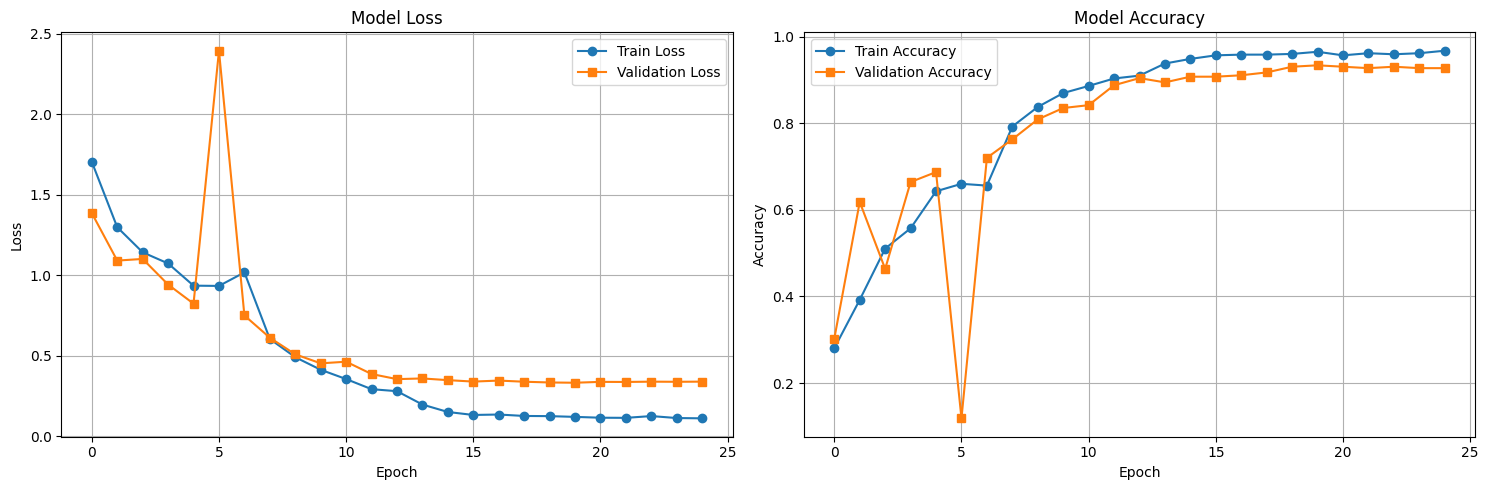

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


Test Accuracy: 33.86%
Test Loss: 4.1494

Classification Report:
              precision    recall  f1-score   support

         HGC       0.83      0.65      0.73        74
         LGC       0.06      0.04      0.05        53
         NST       0.14      0.14      0.14        37
         NTL       0.15      0.36      0.21        25

    accuracy                           0.34       189
   macro avg       0.29      0.30      0.28       189
weighted avg       0.39      0.34      0.35       189


Confusion Matrix:
[[48 20  0  6]
 [ 8  2 19 24]
 [ 0  9  5 23]
 [ 2  3 11  9]]

ROC-AUC Scores:
Macro-average AUC: 0.5556
Micro-average AUC: 0.5474
HGC AUC: 0.8495
LGC AUC: 0.1955
NST AUC: 0.5349
NTL AUC: 0.6427


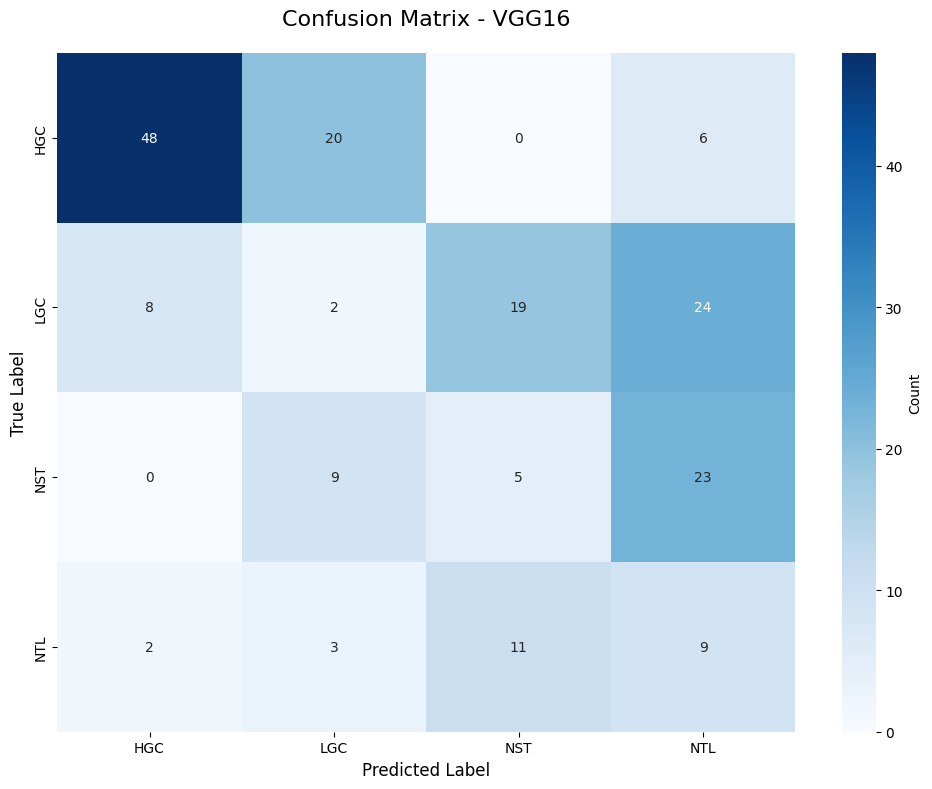

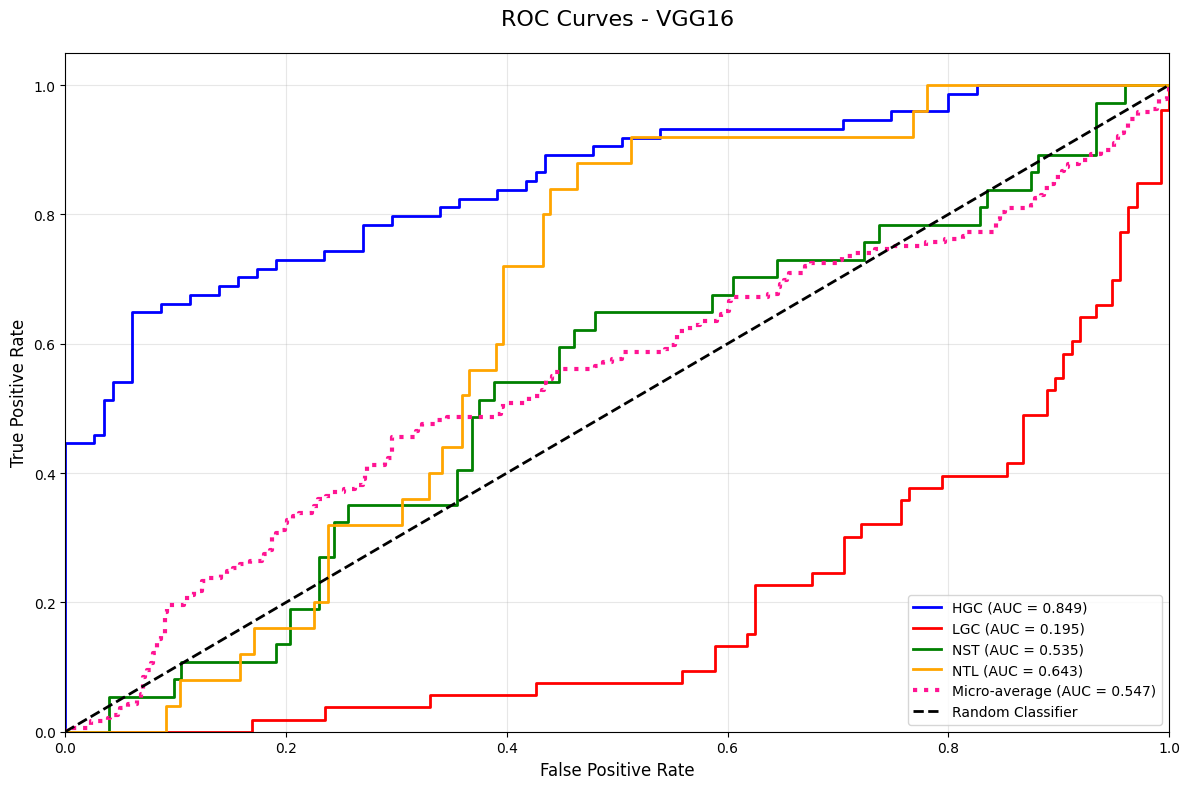


VGG16 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training VGG16 with Imaging Type")
print("=" * 80)

# Create model
vgg16 = create_vgg_model(architecture='vgg16', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_vgg16 = ModelTrainer(vgg16, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vgg16 = trainer_vgg16.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="VGG16_with_ImagingType")

# Plot training history
trainer_vgg16.plot_training_history(save_path='vgg16_training_history.png')

# Evaluate model
results_vgg16 = trainer_vgg16.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vgg16['confusion_matrix'], class_names, 'VGG16',
                      save_path='vgg16_confusion_matrix.png')

# Plot ROC curves
roc_auc_vgg16 = plot_roc_curves(results_vgg16['labels'], results_vgg16['probabilities'], class_names, 'VGG16',
                                save_path='vgg16_roc_curves.png')

# Store results
results_vgg16['model_name'] = 'VGG16_with_ImagingType'
results_vgg16['roc_auc'] = roc_auc_vgg16
all_results.append(results_vgg16)

print("\nVGG16 training and evaluation complete!")

## Train VGG19

Training VGG19 with Imaging Type
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 209MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.22it/s, Loss=1.6463, Acc=0.2730]


Train Loss: 1.6463 Acc: 0.2730 Macro-F1: 0.2506


Val : 100%|██████████| 10/10 [00:01<00:00,  7.52it/s, Loss=1.5186, Acc=0.0724]


Val Loss: 1.5186 Acc: 0.0724 Macro-F1: 0.0337
✓ New best model saved with validation macro-F1: 0.0337

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.22it/s, Loss=1.3857, Acc=0.2763]


Train Loss: 1.3857 Acc: 0.2763 Macro-F1: 0.2599


Val : 100%|██████████| 10/10 [00:01<00:00,  7.47it/s, Loss=1.3912, Acc=0.3684]


Val Loss: 1.3912 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.24it/s, Loss=1.4074, Acc=0.2582]


Train Loss: 1.4074 Acc: 0.2582 Macro-F1: 0.2325


Val : 100%|██████████| 10/10 [00:01<00:00,  7.37it/s, Loss=1.3774, Acc=0.2500]


Val Loss: 1.3774 Acc: 0.2500 Macro-F1: 0.1595
✓ New best model saved with validation macro-F1: 0.1595

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.24it/s, Loss=1.3832, Acc=0.2969]


Train Loss: 1.3832 Acc: 0.2969 Macro-F1: 0.2682


Val : 100%|██████████| 10/10 [00:01<00:00,  7.31it/s, Loss=1.4048, Acc=0.2500]


Val Loss: 1.4048 Acc: 0.2500 Macro-F1: 0.1595

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.24it/s, Loss=1.3969, Acc=0.2689]


Train Loss: 1.3969 Acc: 0.2689 Macro-F1: 0.2421


Val : 100%|██████████| 10/10 [00:01<00:00,  7.40it/s, Loss=1.3842, Acc=0.2895]


Val Loss: 1.3842 Acc: 0.2895 Macro-F1: 0.1768
✓ New best model saved with validation macro-F1: 0.1768

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.22it/s, Loss=1.4064, Acc=0.2418]


Train Loss: 1.4064 Acc: 0.2418 Macro-F1: 0.2271


Val : 100%|██████████| 10/10 [00:01<00:00,  7.41it/s, Loss=1.3840, Acc=0.2895]


Val Loss: 1.3840 Acc: 0.2895 Macro-F1: 0.1768

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.23it/s, Loss=1.3808, Acc=0.2525]


Train Loss: 1.3808 Acc: 0.2525 Macro-F1: 0.2355


Val : 100%|██████████| 10/10 [00:01<00:00,  7.45it/s, Loss=1.3827, Acc=0.2500]


Val Loss: 1.3827 Acc: 0.2500 Macro-F1: 0.1595

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.23it/s, Loss=1.3708, Acc=0.2673]


Train Loss: 1.3708 Acc: 0.2673 Macro-F1: 0.2060


Val : 100%|██████████| 10/10 [00:01<00:00,  7.43it/s, Loss=1.3755, Acc=0.2500]


Val Loss: 1.3755 Acc: 0.2500 Macro-F1: 0.1595

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.24it/s, Loss=1.3732, Acc=0.2681]


Train Loss: 1.3732 Acc: 0.2681 Macro-F1: 0.2402


Val : 100%|██████████| 10/10 [00:01<00:00,  7.48it/s, Loss=1.3660, Acc=0.2895]


Val Loss: 1.3660 Acc: 0.2895 Macro-F1: 0.1768

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.24it/s, Loss=1.3739, Acc=0.2738]


Train Loss: 1.3739 Acc: 0.2738 Macro-F1: 0.2530


Val : 100%|██████████| 10/10 [00:01<00:00,  7.46it/s, Loss=1.3717, Acc=0.2895]


Val Loss: 1.3717 Acc: 0.2895 Macro-F1: 0.1768
Early stopping triggered after 10 epochs
Training complete in 2m 16s
Best validation macro-F1: 0.1768


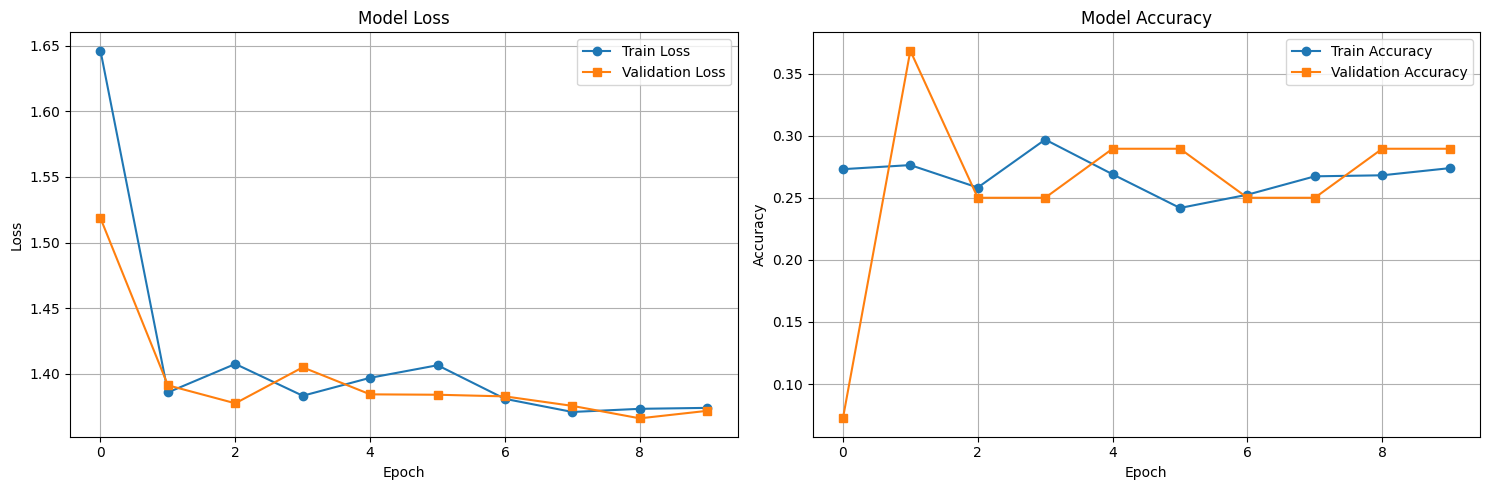

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 32.80%
Test Loss: 1.3809

Classification Report:
              precision    recall  f1-score   support

         HGC       0.41      0.84      0.55        74
         LGC       0.00      0.00      0.00        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.33       189
   macro avg       0.10      0.21      0.14       189
weighted avg       0.16      0.33      0.22       189


Confusion Matrix:
[[62  0  0 12]
 [26  0  0 27]
 [37  0  0  0]
 [25  0  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.4215
Micro-average AUC: 0.5555
HGC AUC: 0.6597
LGC AUC: 0.2048
NST AUC: 0.3705
NTL AUC: 0.4509


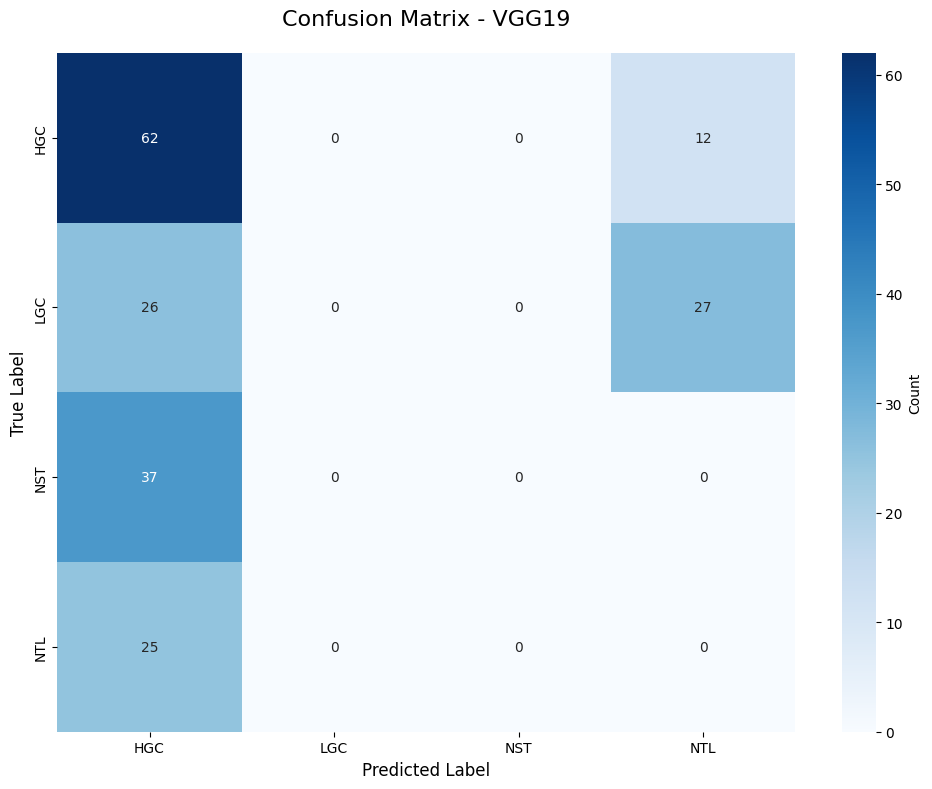

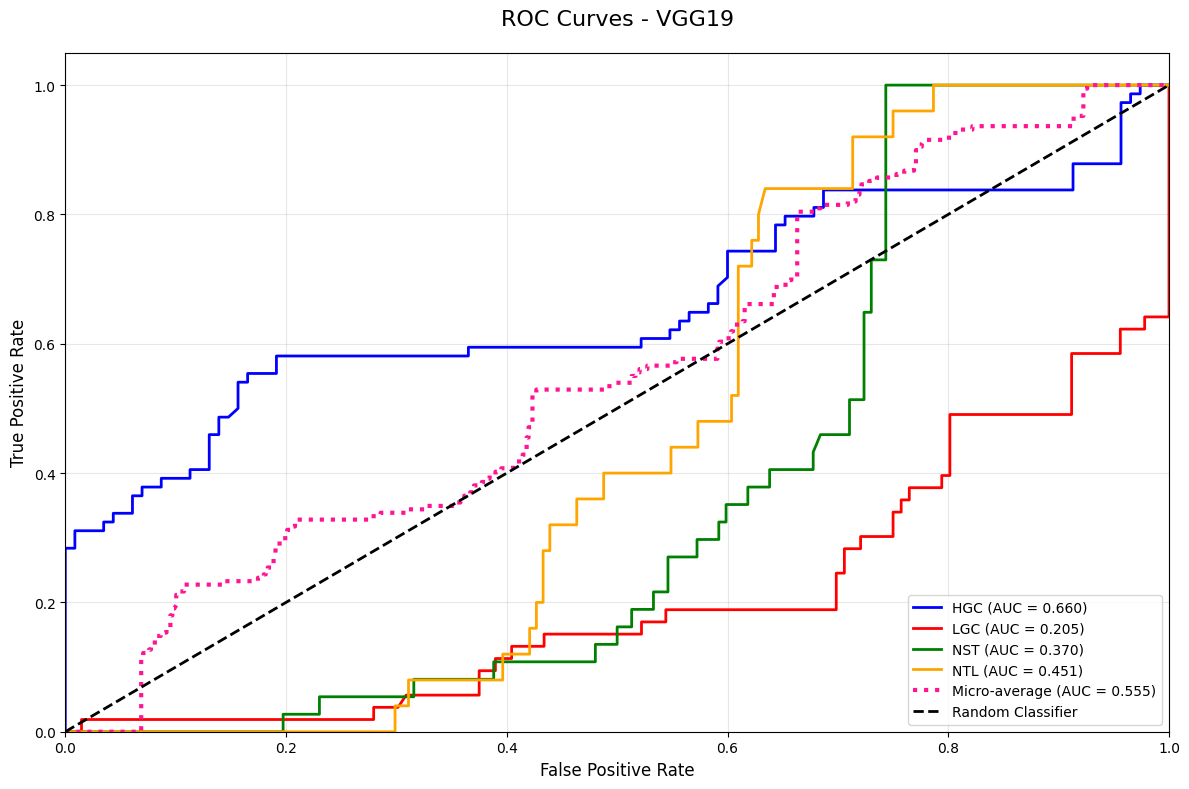


VGG19 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training VGG19 with Imaging Type")
print("=" * 80)

# Create model
vgg19 = create_vgg_model(architecture='vgg19', num_classes=4, num_imaging_types=2, pretrained=True)

# Create trainer
trainer_vgg19 = ModelTrainer(vgg19, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vgg19 = trainer_vgg19.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="VGG19_with_ImagingType")

# Plot training history
trainer_vgg19.plot_training_history(save_path='vgg19_training_history.png')

# Evaluate model
results_vgg19 = trainer_vgg19.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vgg19['confusion_matrix'], class_names, 'VGG19',
                      save_path='vgg19_confusion_matrix.png')

# Plot ROC curves
roc_auc_vgg19 = plot_roc_curves(results_vgg19['labels'], results_vgg19['probabilities'], class_names, 'VGG19',
                                save_path='vgg19_roc_curves.png')

# Store results
results_vgg19['model_name'] = 'VGG19_with_ImagingType'
results_vgg19['roc_auc'] = roc_auc_vgg19
all_results.append(results_vgg19)

print("\nVGG19 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'VGG_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: VGG_metrics.csv

Metrics Summary:
                    Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  VGG16_with_ImagingType         33.862434      4.149382             0.293607          0.295380      0.279759                0.387692             0.338624         0.352202       0.827586    0.648649  0.727273         74.0       0.058824    0.037736  0.045977         53.0       0.142857    0.135135  0.138889         37.0       0.145161        0.36  0.206897         25.0   0.555621   0.547428  0.849471  0.195477  0.534851  0.642683  